In [1]:
import os
import glob
import re
import math
import random
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchcrf import CRF
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
#load data
def load_conll(filename):
    sentences, labels = [], []
    with open(filename, 'r', encoding='utf-8') as f:
        words, tags = [], []
        for line in f:
            line = line.strip()
            if not line:
                if words:
                    sentences.append(words)
                    labels.append(tags)
                    words, tags = [], []
            else:
                word, tag = line.split('\t')
                words.append(word)
                tags.append(tag)
    return sentences, labels

train_sents, train_labels = load_conll('/Users/macbookair/Documents/Data Science 5th Year/Natural Language Processing-NLP/ner_train.conll')
dev_sents, dev_labels = load_conll('/Users/macbookair/Documents/Data Science 5th Year/Natural Language Processing-NLP/ner_dev.conll')
test_sents, test_labels = load_conll('/Users/macbookair/Documents/Data Science 5th Year/Natural Language Processing-NLP/ner_test.conll')

print("Train:", len(train_sents), "Dev:", len(dev_sents), "Test:", len(test_sents))

Train: 17320 Dev: 2165 Test: 2165


In [4]:
all_labels = [l for sent in (train_labels + dev_labels + test_labels) for l in sent]
label_set = sorted(set(all_labels))
label2idx = {l: i for i, l in enumerate(label_set)}
idx2label = {i: l for l, i in label2idx.items()}
print("labels:", label_set)

labels: ['B-LOC', 'B-PER', 'I-LOC', 'I-PER', 'O']


In [5]:
# Count label frequencies in all data
from collections import Counter

label_counts = Counter(all_labels)

print("Label frequencies:")
for label, count in label_counts.most_common():
    print(f"  {label:6}: {count:,}")

Label frequencies:
  O     : 318,671
  I-PER : 38,818
  B-PER : 37,639
  B-LOC : 34,725
  I-LOC : 2,539


In [6]:
from collections import Counter
import torch

# Compute label frequencies
all_labels = [l for sent in (train_labels + dev_labels + test_labels) for l in sent]
label_set = sorted(set(all_labels))
label2idx = {l: i for i, l in enumerate(label_set)}

label_counts = Counter(all_labels)
total = sum(label_counts.values())
class_weights = []

for label in label_set:
    # Inverse frequency weighting
    freq = label_counts[label] / total
    class_weights.append(1.0 / freq)

# Normalize weights
weights = torch.tensor(class_weights, dtype=torch.float)
weights = weights / weights.sum()

# Use in loss function
loss_fn = nn.CrossEntropyLoss(weight=weights)

In [7]:
# Load the trained character-level autoencoder model
class CharAutoencoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=2, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.encoder_gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.decoder_gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.output_fc = nn.Linear(hidden_size, vocab_size)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, input_seq, target_seq=None, teacher_forcing_ratio=0.5):
        embedded = self.embedding(input_seq)
        _, hidden = self.encoder_gru(embedded)
        batch_size, seq_len = input_seq.size()
        decoder_input = input_seq[:, 0].unsqueeze(1)
        outputs = []
        decoder_hidden = hidden
        for t in range(seq_len):
            decoder_embedded = self.embedding(decoder_input)
            decoder_output, decoder_hidden = self.decoder_gru(decoder_embedded, decoder_hidden)
            logits = self.output_fc(decoder_output.squeeze(1))
            outputs.append(logits.unsqueeze(1))
            if target_seq is not None and torch.rand(1).item() < teacher_forcing_ratio:
                next_input = target_seq[:, t].unsqueeze(1)
            else:
                next_input = logits.argmax(dim=1, keepdim=True)
            decoder_input = next_input
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [8]:
# Paste your char2idx mapping here
char2idx = {
    '<PAD>': 0, '<SOS>': 1, '<EOS>': 2, 'ក': 3, 'ខ': 4, 'គ': 5, 'ឃ': 6, 'ង': 7, 'ច': 8, 'ឆ': 9, 'ជ': 10, 'ឈ': 11, 'ញ': 12, 'ដ': 13, 'ឋ': 14, 'ឌ': 15, 'ឍ': 16, 'ណ': 17, 'ត': 18, 'ថ': 19, 'ទ': 20, 'ធ': 21, 'ន': 22, 'ប': 23, 'ផ': 24, 'ព': 25, 'ភ': 26, 'ម': 27, 'យ': 28, 'រ': 29, 'ល': 30, 'វ': 31, 'ឝ': 32, 'ឞ': 33, 'ស': 34, 'ហ': 35, 'ឡ': 36, 'អ': 37, 'ឣ': 38, 'ឤ': 39, 'ឥ': 40, 'ឦ': 41, 'ឧ': 42, 'ឩ': 43, 'ឪ': 44, 'ឫ': 45, 'ឬ': 46, 'ឭ': 47, 'ឮ': 48, 'ឯ': 49, 'ឰ': 50, 'ឱ': 51, 'ឲ': 52, 'ឳ': 53, '឵': 54, 'ា': 55, 'ិ': 56, 'ី': 57, 'ឹ': 58, 'ឺ': 59, 'ុ': 60, 'ូ': 61, 'ួ': 62, 'ើ': 63, 'ឿ': 64, 'ៀ': 65, 'េ': 66, 'ែ': 67, 'ៃ': 68, 'ោ': 69, 'ៅ': 70, 'ំ': 71, 'ះ': 72, 'ៈ': 73, '៉': 74, '៊': 75, '់': 76, '៌': 77, '៍': 78, '៎': 79, '៏': 80, '័': 81, '៑': 82, '្': 83, '៓': 84, '៖': 85, 'ៗ': 86, '៛': 87, '៝': 88, '០': 89, '១': 90, '២': 91, '៣': 92, '៤': 93, '៥': 94, '៦': 95, '៧': 96, '៨': 97, '៩': 98
}

embedding_dim = 128      
hidden_size = 256        
num_layers = 2           
dropout = 0.2            
vocab_size = len(char2idx)
autoencoder = CharAutoencoder(vocab_size, embedding_dim, hidden_size, num_layers, dropout)
autoencoder.load_state_dict(torch.load("/Users/macbookair/Documents/Data Science 5th Year/Natural Language Processing-NLP/char_autoencoder_epoch3.pt", map_location=device))
autoencoder.eval()
autoencoder.to(device)


CharAutoencoder(
  (embedding): Embedding(99, 128, padding_idx=0)
  (encoder_gru): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.2)
  (decoder_gru): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.2)
  (output_fc): Linear(in_features=256, out_features=99, bias=True)
)

In [29]:
print(f"Total Model Parameters: {sum(p.numel() for p in autoencoder.parameters())}")

Total Model Parameters: 1420515


In [31]:
#Test the reconstruction ability of the loaded autoencoder 
def decode_indices(indices, idx2char, eos_token='<EOS>', sos_token='<SOS>'):
    chars = []
    for idx in indices:
        char = idx2char[idx]
        if char == eos_token:
            break
        if char != '<PAD>' and char != sos_token:
            chars.append(char)
    return ''.join(chars)

# Build idx2char from char2idx
char2idx = {
    '<PAD>': 0, '<SOS>': 1, '<EOS>': 2, 'ក': 3, 'ខ': 4, 'គ': 5, 'ឃ': 6, 'ង': 7, 'ច': 8, 'ឆ': 9, 'ជ': 10, 'ឈ': 11, 'ញ': 12, 'ដ': 13, 'ឋ': 14, 'ឌ': 15, 'ឍ': 16, 'ណ': 17, 'ត': 18, 'ថ': 19, 'ទ': 20, 'ធ': 21, 'ន': 22, 'ប': 23, 'ផ': 24, 'ព': 25, 'ភ': 26, 'ម': 27, 'យ': 28, 'រ': 29, 'ល': 30, 'វ': 31, 'ឝ': 32, 'ឞ': 33, 'ស': 34, 'ហ': 35, 'ឡ': 36, 'អ': 37, 'ឣ': 38, 'ឤ': 39, 'ឥ': 40, 'ឦ': 41, 'ឧ': 42, 'ឩ': 43, 'ឪ': 44, 'ឫ': 45, 'ឬ': 46, 'ឭ': 47, 'ឮ': 48, 'ឯ': 49, 'ឰ': 50, 'ឱ': 51, 'ឲ': 52, 'ឳ': 53, '឵': 54, 'ា': 55, 'ិ': 56, 'ី': 57, 'ឹ': 58, 'ឺ': 59, 'ុ': 60, 'ូ': 61, 'ួ': 62, 'ើ': 63, 'ឿ': 64, 'ៀ': 65, 'េ': 66, 'ែ': 67, 'ៃ': 68, 'ោ': 69, 'ៅ': 70, 'ំ': 71, 'ះ': 72, 'ៈ': 73, '៉': 74, '៊': 75, '់': 76, '៌': 77, '៍': 78, '៎': 79, '៏': 80, '័': 81, '៑': 82, '្': 83, '៓': 84, '៖': 85, 'ៗ': 86, '៛': 87, '៝': 88, '០': 89, '១': 90, '២': 91, '៣': 92, '៤': 93, '៥': 94, '៦': 95, '៧': 96, '៨': 97, '៩': 98
}
idx2char = {v: k for k, v in char2idx.items()}

def reconstruction(autoencoder, word, char2idx, idx2char, device, max_len=15):
    autoencoder.eval()
    with torch.no_grad():
        indices = [char2idx.get(c, char2idx['<PAD>']) for c in word]
        indices = [char2idx['<SOS>']] + indices + [char2idx['<EOS>']]
        indices = indices[:max_len] + [char2idx['<PAD>']] * (max_len - len(indices[:max_len]))
        input_tensor = torch.tensor([indices], dtype=torch.long, device=device)
        outputs = autoencoder(input_tensor, teacher_forcing_ratio=0.0)
        pred_indices = outputs.argmax(dim=-1).squeeze(0).cpu().numpy()
        recon = decode_indices(pred_indices, idx2char, eos_token='<EOS>', sos_token='<SOS>')
        orig = decode_indices(indices, idx2char, eos_token='<EOS>', sos_token='<SOS>')
        print(f"Original : {orig}")
        print(f"Recon    : {recon}")

In [35]:
word = "ព្រះរាជាណាចក្រ"
reconstruction(autoencoder, word, char2idx, idx2char, device)

Original : ព្រះរាជាណាចក្រ
Recon    : ព្រះរាជាណាចក្រ


In [ ]:
# Convert sentences to embeddings and labels to indices using autoencoder
def get_word_embedding(word, char2idx, autoencoder, device):
    char_indices = [char2idx.get(c, char2idx['<PAD>']) for c in word]
    char_tensor = torch.tensor(char_indices, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        embedded = autoencoder.embedding(char_tensor)
        _, hidden = autoencoder.encoder_gru(embedded)
    word_emb = hidden[-1].squeeze(0)  # [hidden_size]
    return word_emb.cpu().numpy()

def prepare_data(sentences, labels, char2idx, autoencoder, device, label2idx):
    X, y = [], []
    for sent, label_seq in zip(sentences, labels):
        word_embs = [get_word_embedding(word, char2idx, autoencoder, device) for word in sent]
        label_ids = [label2idx[l] for l in label_seq]
        X.append(word_embs)
        y.append(label_ids)
    return X, y

# Prepare train/dev/test sets
X_train, y_train = prepare_data(train_sents, train_labels, char2idx, autoencoder, device, label2idx)
X_dev, y_dev = prepare_data(dev_sents, dev_labels, char2idx, autoencoder, device, label2idx)
X_test, y_test = prepare_data(test_sents, test_labels, char2idx, autoencoder, device, label2idx)


In [ ]:
lengths = [len(sent) for sent in train_sents]
print("Min length:", min(lengths))
print("Max length:", max(lengths))
print("Average length:", sum(lengths)/len(lengths))

Min length: 4
Max length: 120
Average length: 19.908718244803694


In [21]:
# Count total words in all splits
total_words = sum(len(sent) for sent in train_sents + dev_sents + test_sents)
print("Total words:", total_words)

# Preview a few sentences and their labels
for i in range(3):  # Show first 3 sentences
    print("Sentence:", train_sents[i])
    print("Labels:  ", train_labels[i])
    print("---")

Total words: 432392
Sentence: ['ហ៊ុន', 'វឌ្ឍន', 'កំពុងធ្វើបាតុកម្មជាមួយនឹងក្រុមគាំទ្រ', '-', 'ប៉ាឡេស្ទីនប្រឆាំងនឹងការវាយឆ្មក់របស់', 'ខេត្តព្រះវិហារ', 'លើ', 'Flotilla', 'ចង', 'ប្រទេសបាបាដូស', 'ដែលបានសម្លាប់សកម្មជនទួរគី', '9', 'នាក់។']
Labels:   ['B-PER', 'I-PER', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O']
---
Sentence: ['កិច្ចពិភាក្សារបស់លោក', 'ហុង', 'រង្សីរតនរង្សី', 'ក៏ត្រូវបានគេរំពឹងថានឹងផ្តោតលើជំនួយទួរគីសម្រាប់', 'ស្រុកសាលាក្រៅ', 'ដើម្បីយកឈ្នះលើការខ្វះខាតទឹក', 'និងថាមពល។']
Labels:   ['O', 'B-PER', 'I-PER', 'O', 'B-LOC', 'O', 'O']
---
Sentence: ['អ្នកកាសែត', 'BBC', 'ខា', 'កាន់យ៉ាកុលាប', 'ដែលចេញផ្សាយកាលពីថ្ងៃពុធដោយក្រុមចាប់ជំរិតប៉ាឡេស្ទីននៅ', 'សង្កាត់ក្រាំងពង្រ', 'បានទទួលពានរង្វាន់សម្រាប់ការរាយការណ៍សិទ្ធិមនុស្សពីអង្គការលើកលែងទោសអន្តរជាតិ។']
Labels:   ['O', 'O', 'B-PER', 'I-PER', 'O', 'B-LOC', 'O']
---


In [22]:
print("First sentence:", train_sents[0])
print("First sentence embeddings (shape):", [emb.shape for emb in X_train[0]])
for i, (word, emb) in enumerate(zip(train_sents[0], X_train[0])):
    print(f"Word: {word}")
    print(f"Embedding vector (first 10 values): {emb[:10]}")
    print(f"Vector shape: {emb.shape}")
    print("---")

First sentence: ['ហ៊ុន', 'វឌ្ឍន', 'កំពុងធ្វើបាតុកម្មជាមួយនឹងក្រុមគាំទ្រ', '-', 'ប៉ាឡេស្ទីនប្រឆាំងនឹងការវាយឆ្មក់របស់', 'ខេត្តព្រះវិហារ', 'លើ', 'Flotilla', 'ចង', 'ប្រទេសបាបាដូស', 'ដែលបានសម្លាប់សកម្មជនទួរគី', '9', 'នាក់។']
First sentence embeddings (shape): [(256,), (256,), (256,), (256,), (256,), (256,), (256,), (256,), (256,), (256,), (256,), (256,), (256,)]
Word: ហ៊ុន
Embedding vector (first 10 values): [ 2.3808479e-03 -1.0000000e+00  4.6713352e-02 -9.5939147e-01
 -6.6979408e-02 -9.9856031e-01  4.2705595e-02 -1.4276385e-02
  4.2301416e-04  9.8418367e-01]
Vector shape: (256,)
---
Word: វឌ្ឍន
Embedding vector (first 10 values): [ 0.01435745 -1.         -0.02380669 -0.9911712   0.06967223  0.99555683
  0.05975389  0.04883194  0.01260948  0.00138909]
Vector shape: (256,)
---
Word: កំពុងធ្វើបាតុកម្មជាមួយនឹងក្រុមគាំទ្រ
Embedding vector (first 10 values): [ 0.00250632 -1.          0.5155967   0.49588835 -0.10908151  0.7360363
  0.02877444  0.00310647  0.01642942  0.35800207]
Vector shape: (25

In [ ]:
#DataLoader and batching for variable-length sentences
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  # List of [seq_len, emb_dim] arrays
        self.y = y  # List of [seq_len] label lists
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return np.array(self.X[idx]), np.array(self.y[idx])

def pad_collate(batch):
    # batch: list of (X, y) tuples
    Xs, ys = zip(*batch)
    lengths = [len(x) for x in Xs]
    max_len = max(lengths)
    emb_dim = Xs[0].shape[1]
    # Pad X
    X_padded = np.zeros((len(Xs), max_len, emb_dim), dtype=np.float32)
    for i, x in enumerate(Xs):
        X_padded[i, :len(x), :] = x
    # Pad y
    y_padded = np.full((len(ys), max_len), fill_value=-1, dtype=np.int64)  # -1 for ignore index
    for i, y in enumerate(ys):
        y_padded[i, :len(y)] = y
    # Mask: 1 for real tokens, 0 for pad
    mask = (y_padded != -1)
    return (
        torch.tensor(X_padded),
        torch.tensor(y_padded),
        torch.tensor(mask, dtype=torch.bool)
    )

In [ ]:
#Training
train_dataset = NERDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)

#validation/test:
dev_dataset = NERDataset(X_dev, y_dev)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate)
test_dataset = NERDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate)

# Inspect a batch
for X_batch, y_batch, mask in train_loader:
    print("X_batch shape:", X_batch.shape)  # (batch, max_len, emb_dim)
    print("y_batch shape:", y_batch.shape)  # (batch, max_len)
    print("mask shape:", mask.shape)        # (batch, max_len)
    print("First mask row:", mask[0])
    break

# NER Model 

In [12]:
class BiLSTM_CRF(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tagset_size):
        super().__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, embeds):
        # embeds: (batch, seq_len, embedding_dim)
        lstm_out, _ = self.lstm(embeds)
        emissions = self.hidden2tag(lstm_out)
        return emissions

    def loss(self, embeds, tags, mask):
        emissions = self.forward(embeds)
        return -self.crf(emissions, tags, mask=mask, reduction='mean')

    def predict(self, embeds, mask):
        emissions = self.forward(embeds)
        return self.crf.decode(emissions, mask=mask)

In [13]:
#instantiation:
tagset_size = len(label2idx)
hidden_dim = 128
embedding_dim = 256 

model = BiLSTM_CRF(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    tagset_size=tagset_size
).to(device)

print(model)

BiLSTM_CRF(
  (lstm): LSTM(256, 64, batch_first=True, bidirectional=True)
  (hidden2tag): Linear(in_features=128, out_features=5, bias=True)
  (crf): CRF(num_tags=5)
)


In [14]:
num_epochs = 10
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
best_val_loss = float('inf')

In [33]:
# Training 
train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch, mask in tqdm(train_loader, desc=f"Epoch {epoch} - Training"):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        loss = model.loss(X_batch, y_batch, mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch, mask in tqdm(dev_loader, desc=f"Epoch {epoch} - Validation"):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            mask = mask.to(device)
            loss = model.loss(X_batch, y_batch, mask)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(dev_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch} - Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "bilstm_crf_best.pt")
        print("Best model saved!")

print("Training complete.")

Epoch 1 - Training: 100%|██████████| 542/542 [01:33<00:00,  5.81it/s]


Epoch 1 - Train Loss: 3.9166


Epoch 1 - Validation: 100%|██████████| 68/68 [00:04<00:00, 16.18it/s]


Epoch 1 - Val Loss: 1.2513
Best model saved!


Epoch 2 - Training: 100%|██████████| 542/542 [01:08<00:00,  7.92it/s]


Epoch 2 - Train Loss: 0.9732


Epoch 2 - Validation: 100%|██████████| 68/68 [00:03<00:00, 18.58it/s]


Epoch 2 - Val Loss: 0.8076
Best model saved!


Epoch 3 - Training: 100%|██████████| 542/542 [01:05<00:00,  8.33it/s]


Epoch 3 - Train Loss: 0.6394


Epoch 3 - Validation: 100%|██████████| 68/68 [00:03<00:00, 18.64it/s]


Epoch 3 - Val Loss: 0.6073
Best model saved!


Epoch 4 - Training: 100%|██████████| 542/542 [01:04<00:00,  8.36it/s]


Epoch 4 - Train Loss: 0.4662


Epoch 4 - Validation: 100%|██████████| 68/68 [00:03<00:00, 19.32it/s]


Epoch 4 - Val Loss: 0.5026
Best model saved!


Epoch 5 - Training: 100%|██████████| 542/542 [01:10<00:00,  7.74it/s]


Epoch 5 - Train Loss: 0.3549


Epoch 5 - Validation: 100%|██████████| 68/68 [00:03<00:00, 20.47it/s]


Epoch 5 - Val Loss: 0.4568
Best model saved!


Epoch 6 - Training: 100%|██████████| 542/542 [01:08<00:00,  7.91it/s]


Epoch 6 - Train Loss: 0.2701


Epoch 6 - Validation: 100%|██████████| 68/68 [00:03<00:00, 18.35it/s]


Epoch 6 - Val Loss: 0.3947
Best model saved!


Epoch 7 - Training: 100%|██████████| 542/542 [01:05<00:00,  8.29it/s]


Epoch 7 - Train Loss: 0.2144


Epoch 7 - Validation: 100%|██████████| 68/68 [00:03<00:00, 18.93it/s]


Epoch 7 - Val Loss: 0.3583
Best model saved!


Epoch 8 - Training: 100%|██████████| 542/542 [01:08<00:00,  7.92it/s]


Epoch 8 - Train Loss: 0.1695


Epoch 8 - Validation: 100%|██████████| 68/68 [00:03<00:00, 18.59it/s]


Epoch 8 - Val Loss: 0.3476
Best model saved!


Epoch 9 - Training: 100%|██████████| 542/542 [01:05<00:00,  8.26it/s]


Epoch 9 - Train Loss: 0.1326


Epoch 9 - Validation: 100%|██████████| 68/68 [00:03<00:00, 19.03it/s]


Epoch 9 - Val Loss: 0.3288
Best model saved!


Epoch 10 - Training: 100%|██████████| 542/542 [01:06<00:00,  8.20it/s]


Epoch 10 - Train Loss: 0.1063


Epoch 10 - Validation: 100%|██████████| 68/68 [00:03<00:00, 19.93it/s]


Epoch 10 - Val Loss: 0.2803
Best model saved!
Training complete.


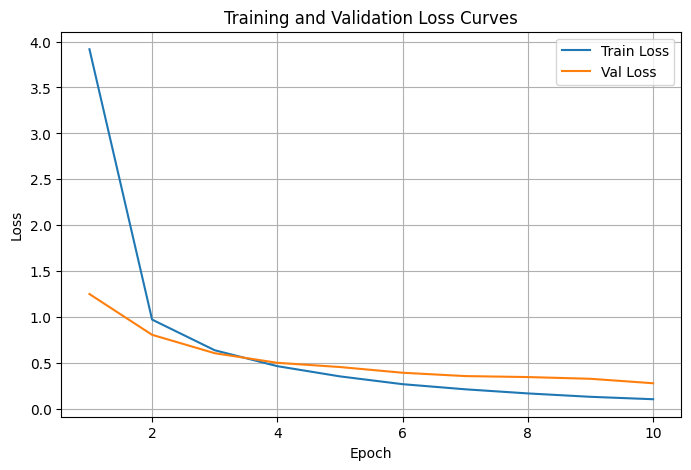

In [34]:
# Visualize training and validation loss curves
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
epochs = range(1, len(train_losses) + 1)
sns.lineplot(x=epochs, y=train_losses, label='Train Loss')
sns.lineplot(x=epochs, y=val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Load best model
model.load_state_dict(torch.load("bilstm_crf_best.pt", map_location=device))
model.eval()

BiLSTM_CRF(
  (lstm): LSTM(256, 64, batch_first=True, bidirectional=True)
  (hidden2tag): Linear(in_features=128, out_features=5, bias=True)
  (crf): CRF(num_tags=5)
)

In [ ]:
# Evaluate on test set and print classification report
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch, mask in tqdm(test_loader, desc="Testing"):
        X_batch = X_batch.to(device)
        y_batch = y_batch.cpu().numpy()
        mask = mask.cpu().numpy()
        preds = model.predict(X_batch, torch.tensor(mask, dtype=torch.bool, device=device))
        for i in range(len(preds)):
            true_labels = y_batch[i][mask[i]]
            pred_labels = preds[i]
            y_true.extend(true_labels)
            y_pred.extend(pred_labels)

# Remove ignored indices if any
valid_idx = [i for i, t in enumerate(y_true) if t != -1]
y_true = np.array(y_true)[valid_idx]
y_pred = np.array(y_pred)[valid_idx]

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# Classification report
print(classification_report(y_true, y_pred, target_names=[idx2label[i] for i in range(len(label2idx))]))

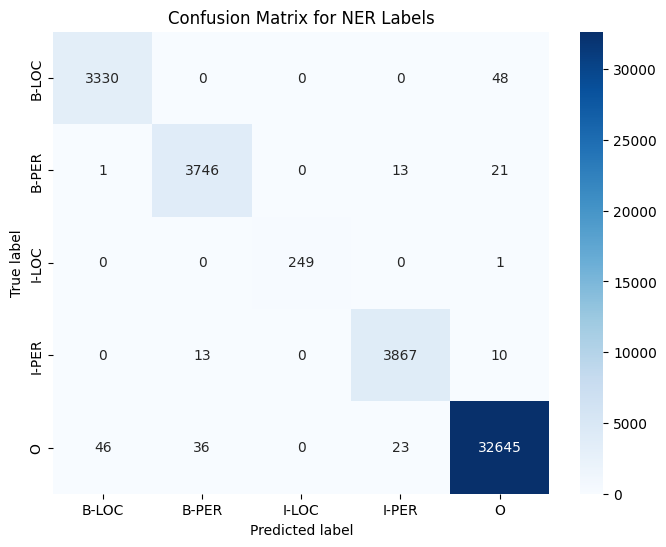

In [38]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[idx2label[i] for i in range(len(label2idx))], yticklabels=[idx2label[i] for i in range(len(label2idx))])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for NER Labels')
plt.show()

In [17]:
def predict_sentence_ner(sentence, model, char2idx, autoencoder, idx2label, device="cpu"):
    model.eval()
    tokens = sentence.strip().split()
    # Get char-level embeddings for each word
    word_embs = [get_word_embedding(word, char2idx, autoencoder, device) for word in tokens]
    X = torch.tensor([word_embs], dtype=torch.float32).to(device)  # [1, seq_len, emb_dim]
    mask = torch.ones(1, len(tokens), dtype=torch.bool).to(device)
    with torch.no_grad():
        pred_ids = model.predict(X, mask)[0]
    pred_labels = [idx2label[i] for i in pred_ids]
    for w, tag in zip(tokens, pred_labels):
        print(f"{w:<20s} {tag}")

# Example 

In [19]:

sentence = "មណីយដ្ឋានធម្មជាតិ ឆ្នេរខ្សាច់កោះប៉ែន និង ស្ពានប្រដឺសឬស្សី១.០០០ម៉ែត្រ សូមស្វាគមន៍ភ្ញៀវទេសចរណ៍"
predict_sentence_ner(sentence, model, char2idx, autoencoder, idx2label, device)

មណីយដ្ឋានធម្មជាតិ    O
ឆ្នេរខ្សាច់កោះប៉ែន   O
និង                  O
ស្ពានប្រដឺសឬស្សី១.០០០ម៉ែត្រ B-LOC
សូមស្វាគមន៍ភ្ញៀវទេសចរណ៍ O


In [20]:
sentence = "អំណោយរបស់ សម្តេចបវរធិបតី ហ៊ុន ម៉ាណែត និង លោកជំទាវបណ្ឌិត ត្រូវបាន បណ្ឌិត គុណ ញឹម បន្តនាំយកទៅប្រគល់ជូនដល់វីរកងទ័ពជួរមុខ ដែល កំពុង ឈរជើង ការពារ បូរណភាពទឹកដី តាម បណ្តោយ ព្រំដែន កម្ពុជា-ថៃ"
predict_sentence_ner(sentence, model, char2idx, autoencoder, idx2label, device)

អំណោយរបស់            O
សម្តេចបវរធិបតី       O
ហ៊ុន                 B-PER
ម៉ាណែត               I-PER
និង                  O
លោកជំទាវបណ្ឌិត       O
ត្រូវបាន             O
បណ្ឌិត               O
គុណ                  B-PER
ញឹម                  I-PER
បន្តនាំយកទៅប្រគល់ជូនដល់វីរកងទ័ពជួរមុខ O
ដែល                  O
កំពុង                O
ឈរជើង                O
ការពារ               O
បូរណភាពទឹកដី         O
តាម                  O
បណ្តោយ               O
ព្រំដែន              O
កម្ពុជា-ថៃ           O


zzzz

In [21]:

sentence = "លោកជំទាវបណ្ឌិត ពេជ ចន្ទមុន្នី ហ៊ុន ម៉ាណែត បន្តប្រគេនភេសជ្ជៈ, គ្រឿងឧបភោគ-បរិភោគ និង បច្ច័យ ដល់ ព្រះសង្ឃ គង់ នៅ វត្តប្រាសាទនាងខ្មៅ ខេត្តតាកែវ"
predict_sentence_ner(sentence, model, char2idx, autoencoder, idx2label, device)

លោកជំទាវបណ្ឌិត       O
ពេជ                  B-PER
ចន្ទមុន្នី           I-PER
ហ៊ុន                 B-PER
ម៉ាណែត               I-PER
បន្តប្រគេនភេសជ្ជៈ,   O
គ្រឿងឧបភោគ-បរិភោគ    O
និង                  O
បច្ច័យ               O
ដល់                  O
ព្រះសង្ឃ             O
គង់                  O
នៅ                   O
វត្តប្រាសាទនាងខ្មៅ   O
ខេត្តតាកែវ           B-LOC


In [37]:

sentence = "លោក អឿន ប៉ាវ ទៅ លេង ខេត្តកំពត"
predict_sentence_ner(sentence, model, char2idx, autoencoder, idx2label, device)

លោក                  O
អឿន                  B-PER
ប៉ាវ                 I-PER
ទៅ                   O
លេង                  O
ខេត្តកំពត            B-LOC
